## Fit and cross-validate reference model

Create ..\..\reference_model_results\selected_features\rbred
Create ..\..\reference_models_trained\final_reference_models\rbred
Create ..\..\reference_models_trained\nested_cv_reference_models\rbred
Create ..\..\reference_model_results\reference_models_evaluation\rbred


07-28-2024 02:08:11 - __reference_model_rbred__ - INFO - (360, 19)
07-28-2024 02:08:11 - __reference_model_rbred__ - INFO - 
############ Applying RandomForestRegressor on rbred ############
 
07-28-2024 02:08:11 - __reference_model_rbred__ - INFO - Predictor names: ['inundation duration', 'water depth', 'contaminations', 'flow velocity', 'flood experience', 'building age', 'building area', 'mthly. income', 'emergency measures', 'no. employees', 'non-structural measures', 'structural measures', 'resilience', 'mthly. sales']
07-28-2024 02:08:11 - __reference_model_rbred__ - INFO - Removing 0 records from entire dataset due that these values are nan in target variable
07-28-2024 02:08:11 - __reference_model_rbred__ - INFO - Finally use 313 records for feature extraction, from those are 127 cases with zero-loss or zero-reduction


Dropping records with missing values


07-28-2024 02:08:33 - __reference_model_rbred__ - INFO - Performance of best estimators on outer test-sets:
07-28-2024 02:08:33 - __reference_model_rbred__ - INFO - Params of best model: {'model__random_state': 42, 'model__n_estimators': 100}
07-28-2024 02:08:33 - __reference_model_rbred__ - INFO - Performance of best model:


RandomForestRegressor:  {'model__random_state': 42, 'model__n_estimators': 100}
RandomForestRegressor:  {'model__random_state': 42, 'model__n_estimators': 100}
RandomForestRegressor:  {'model__random_state': 42, 'model__n_estimators': 100}
RandomForestRegressor:  {'model__random_state': 42, 'model__n_estimators': 100}
RandomForestRegressor:  {'model__random_state': 42, 'model__n_estimators': 100}
test_MAE 14.937777777777773
test_RMSE 19.56283916486756
test_MBE 4.468571428571428
test_SMAPE -58.90353531571059


07-28-2024 02:09:42 - __reference_model_rbred__ - INFO - 
Select features based on permutation feature importance
07-28-2024 02:09:42 - __reference_model_rbred__ - INFO - 5 most important features: ['building age', 'emergency measures', 'water depth', 'building area', 'inundation duration']
07-28-2024 02:09:42 - __reference_model_rbred__ - INFO - 
Training and evaluation of RandomForestRegressor took 1.5151445833333335 minutes

07-28-2024 02:09:42 - __reference_model_rbred__ - INFO - Creating boxplots for range of performane scores from outer folds of nested cross-validation
07-28-2024 02:09:49 - __reference_model_rbred__ - INFO - Outer evaluation scores of nested cross-validation (median) :
        RandomForestRegressor_score  RandomForestRegressor_score_std
MAE                         16.175                            1.176
RMSE                        21.733                            2.680
MBE                          2.005                            2.708
SMAPE                     

<Figure size 2000x1000 with 0 Axes>

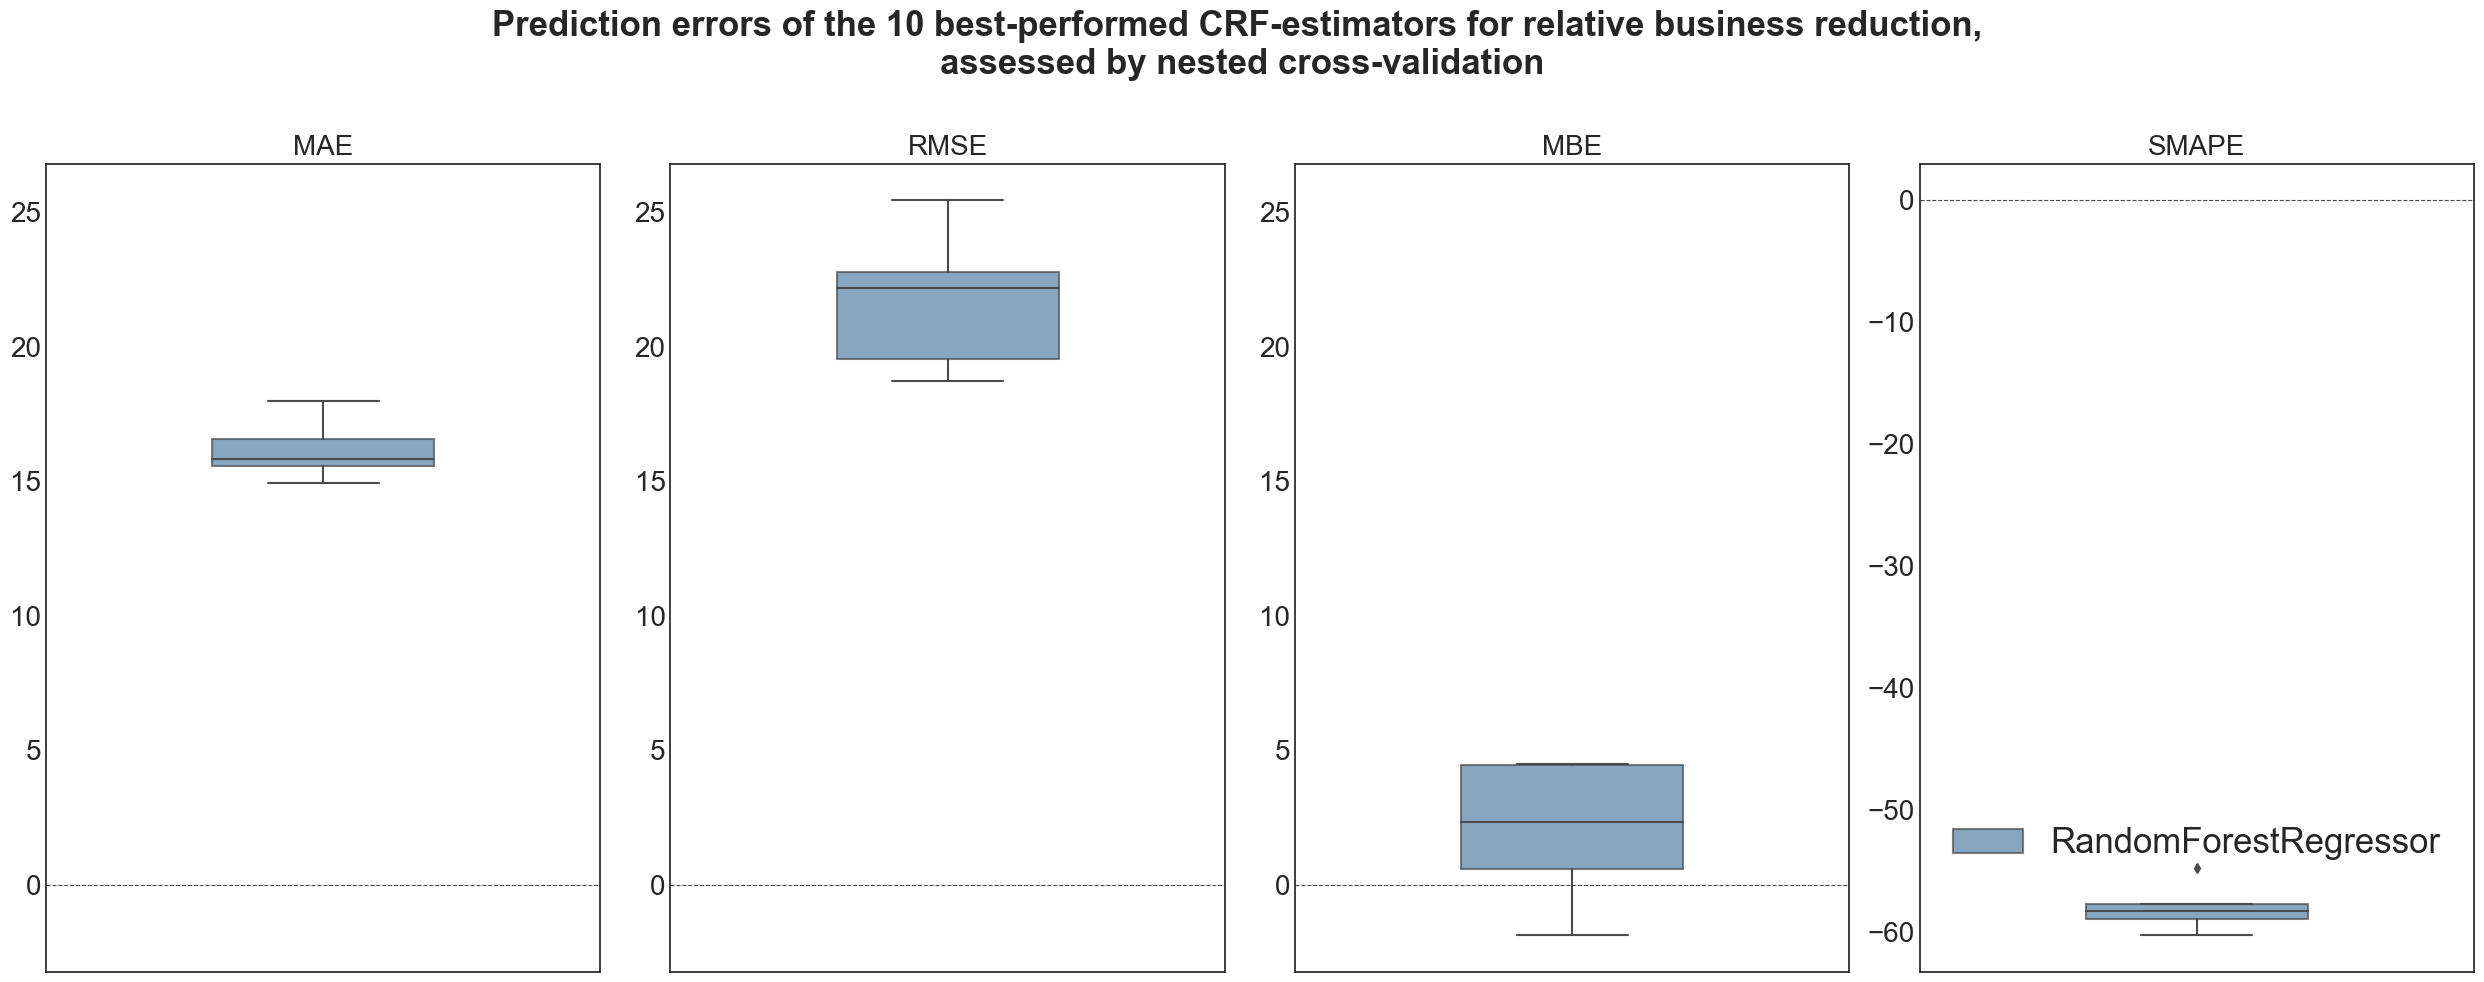

<Figure size 3000x2200 with 0 Axes>

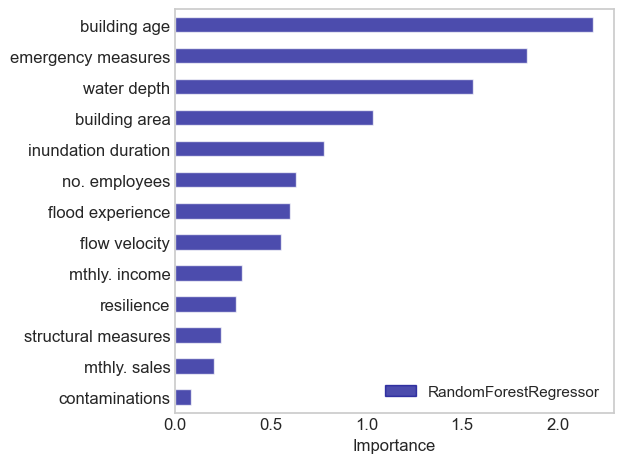

07-28-2024 02:09:50 - __reference_model_rbred__ - INFO - Dropping 0 records from entire dataset due that these values are nan in target variable
07-28-2024 02:09:50 - __reference_model_rbred__ - INFO - Keeping 360 records and 19 features
07-28-2024 02:09:50 - __reference_model_rbred__ - INFO - 
RandomForestRegressor observed and predicted target distirbution from cross-valdiated outer folds:
07-28-2024 02:09:50 - __reference_model_rbred__ - INFO -            nobs  median       mean   min max  variance  standard deviation   
empirical   313    10.0  17.814696  [0, 100]    589.34               24.24  \
predicted   313    18.0  20.127796   [2, 75]    147.77               12.14   

           coef. of variation  
empirical          136.271035  
predicted           60.393550  
07-28-2024 02:09:50 - __reference_model_rbred__ - INFO - 
Observed and predicted target distirbution from final model:
07-28-2024 02:09:50 - __reference_model_rbred__ - INFO -            nobs  median       mean   min 

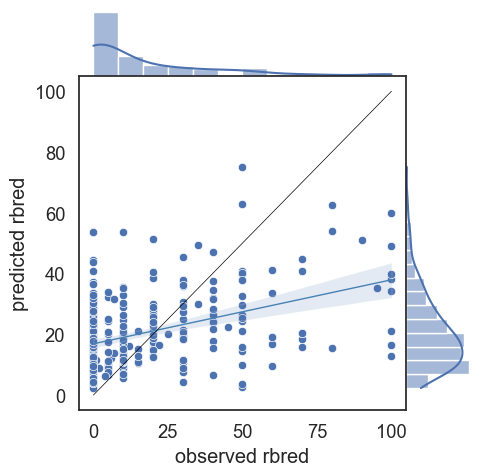

In [25]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Reference model"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

# Reference model to compare with BN results

"""
NOTE: 
- reference mode to predict rcloss and bred 
- use reference model to verify BN performances for HCMC ds and CanTho Dataset
- for rcloss: train with zero-loss cases, aim is to compare applied approach (chance-of-loss + degree-of-loss + BN)
- always basic set of hyperparameters is used (no tuning),
- evaluate with 10 fold cross-valdiation
"""

import sys, os
from datetime import datetime
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import make_scorer, mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

UTILS_PATH = os.path.join(os.path.abspath(""), "../", "utils")
sys.path.append(UTILS_PATH)
import training as t
import evaluation as e
import evaluation_utils as eu
import figures as f
import settings as s
import preprocessing as pp

# p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import contextlib
import warnings
warnings.filterwarnings('ignore')


## settings for cv
kfolds_and_repeats = 5, 1  # <k-folds, repeats> for nested cv  - reference RF model has no hyperparameter tuning, thus no repeats in folds=1
inner_cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=kfolds_and_repeats[1], random_state=seed)
outer_cv = RepeatedKFold(n_splits=kfolds_and_repeats[0], n_repeats=1, random_state=seed) # make same as for R nestedcv.train()


targets = [
    ("rcloss", "relative content loss",  ("darkgrey", "steelblue")), 
    ("rbred","relative business reduction",  ("darkgrey", "steelblue"))]

target, target_plot, hue_colors = targets[1]   # <-- change here target variable (flood loss variable)

# Get and init logger
main_logger = f"__reference_model_{target}__"
logger = s.init_logger(main_logger)


## save models and their evaluation in following folders:
INPATH_DATA = Path(f"../{s.INPATH_DATA}") # input path
OUTPATH_FEATURES, OUTPATH_FINALMODELS, OUTPATH_ESTIMATORS_NCV, OUTPATH_RESULTS = [ # create output paths
    pp.create_output_dir(Path("../", re.sub(r"(model)", rf"reference_\1", d)) / target) for d in  # re.sub(r"(model)": add prefix to filepath name
    [s.OUTPATH_FEATURES, s.OUTPATH_FINALMODELS, s.OUTPATH_ESTIMATORS_NCV, s.OUTPATH_EVAL]
]


## load candidate predictors and target for HCMC
# df_candidates = pd.read_excel(f"{INPATH_DATA}/input_data_contentloss_tueb.xlsx")
df_candidates = pd.read_excel(f"{INPATH_DATA}/input_data_businessreduction_tueb.xlsx")

## load candidate predictors and target for CanTho
# df_cantho = pd.read_excel(f"{INPATH_DATA}/input_data_contentloss_cantho.xlsx")
df_cantho = pd.read_excel(f"{INPATH_DATA}/input_data_businessreduction_cantho.xlsx")


##  use nice feature names
df_candidates.rename(columns=s.feature_names_plot, inplace=True) 


  
logger.info(df_candidates.shape)

## Evaluation metrics 
score_metrics = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(eu.root_mean_squared_error, greater_is_better=False),
    "MBE": make_scorer(eu.mean_bias_error, greater_is_better=False),
    # "R2": "r2",
    "SMAPE": make_scorer(eu.symmetric_mean_absolute_percentage_error, greater_is_better=False)
}



## empty variables to store model outputs
eval_sets = {}
models_trained = {}
final_models_trained = {}
models_coef = {}
predicted_values = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

## iterate over piplines. Each pipline contains a scaler and regressor (and optionally a bagging method) 
pipelines = ["pipe_ref_model"]  

## Load set of hyperparamters
hyperparams_set = pp.load_config(f"{UTILS_PATH}/hyperparameter_sets.json")


for pipe_name in pipelines:

    TIME0 = datetime.now()

    ## load model pipelines
    pipe = joblib.load(f"{UTILS_PATH}/pipelines/{pipe_name}.pkl")
  
    try:
        model_name = re.findall("[a-zA-Z]+", str(pipe.steps[1][1].__class__).split(".")[-1])[0] # get model name for python models  
    except AttributeError:
        model_name = pipe # get R model name
    
    ## load respective hyperparameter space
    param_space = hyperparams_set[f"{model_name}_hyperparameters"]

    ## if bagging fro model training is used , rename hyperparmeters
    if "bag" in pipe_name.split("_"):
        logger.info(f"Testing {model_name} with bagging")
        param_space = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_space.items()}



    logger.info( f"\n############ Applying {model_name} on {target} ############\n ")

    # save original df for later
    df_Xy = df_candidates


    # rm geometry column which only needed for visualization
    
    with contextlib.suppress(Exception):

        df_Xy = df_Xy.drop("geometry", axis=1)
        if target == "rcloss":
            df_Xy.drop("shp_content_value_euro", axis=1, inplace=True) 
            df_Xy.drop("closs", axis=1, inplace=True) 
            df_Xy.drop("shp_sector", axis=1, inplace=True) 
            df_Xy.drop("shp_business_limitation", axis=1, inplace=True) 
        if target == "rbred":
            df_Xy.drop("shp_business_limitation", axis=1, inplace=True) 
            df_Xy.drop("shp_content_value_euro", axis=1, inplace=True) 
            df_Xy.drop("shp_sector", axis=1, inplace=True) 

            # df_candidates.drop("hh_monthly_income_euro", axis=1, inplace=True) 


    # get predictor names
    X_names = df_Xy.drop(target, axis=1).columns.to_list()
    logger.info(f"Predictor names: {X_names}")

    ## drop samples where target is nan
    logger.info(f"Removing {df_Xy[target].isna().sum()} records from entire dataset due that these values are nan in target variable")
    # df_Xy = df_Xy[ ~df_Xy[target].isna()]

    ## Elastic Net and Random Forest: drop samples where any value is nan
    if (model_name == "RandomForestRegressor") | (model_name == "ElasticNet") | (model_name == "cforest"):
        print("Dropping records with missing values")
        df_Xy.dropna(inplace=True)

    logger.info(
        f"Finally use {df_Xy.shape[0]} records for feature extraction, from those are {(df_Xy[target][df_Xy[target] == 0.0]).count()} cases with zero-loss or zero-reduction",
    )

    X = df_Xy[X_names]
    y = df_Xy[target]

 
    ## run sklearn model
    # print("value ranges of features:", df_Xy.describe())

    ## fit model for unbiased model evaluation and for final model used for Feature importance, Partial Dependence etc.
    mf = t.ModelFitting(
        model=pipe, 
        Xy=df_Xy,
        target_name=target,
        param_space=param_space,
        tuning_score=score_metrics["MAE"], # tune by getting reducing MAE
        cv=inner_cv,
        kfolds_and_repeats=kfolds_and_repeats,
        seed=seed,
    )
    models_trained_ncv = mf.model_fit_ncv()

    # save models from nested cv and final model on entire ds
    joblib.dump(models_trained_ncv, f"{OUTPATH_ESTIMATORS_NCV}/{model_name}_{target}.joblib")
        
    ## evaluate model    
    me = e.ModelEvaluation(
        models_trained_ncv=models_trained_ncv, 
        Xy=df_Xy,
        target_name=target,
        score_metrics=score_metrics,
        cv=outer_cv,
        kfolds=kfolds_and_repeats[0],
        seed=seed,
    )
    model_evaluation_results = me.model_evaluate_ncv()

    
    ## visual check if hyperparameter ranges are good or need to be adapted
    logger.info(f"Performance of best estimators on outer test-sets:") 
    for i in range(len(model_evaluation_results["estimator"])):
        print(f"{model_name}: ", model_evaluation_results["estimator"][i].best_params_)


    ## store models evaluation 
    models_scores[model_name] =  {
        k: model_evaluation_results[k] for k in tuple("test_" + s for s in list(score_metrics.keys()))
    } # get evaluation scores, metric names start with "test_<metricname>"
    
    ## reverse sklearn.cross_validate() outputted regression scores (e.g. MAE, RMSE, SMAPE, R2)
    models_scores[model_name] = me.negate_scores_from_sklearn_cross_valdiate(models_scores[model_name])


    ## Final model

    ## get final model based on best MAE score during outer cv
    best_idx = list(models_scores[model_name]["test_MAE"]).index(min(models_scores[model_name]["test_MAE"]))
    final_model = model_evaluation_results["estimator"][best_idx]
    logger.info(f"Params of best model: {final_model.best_params_}") 
    final_model = final_model.best_estimator_

    logger.info(f"Performance of best model:") 
    for metric in models_scores[model_name].keys():
        print(metric, models_scores[model_name][metric][best_idx])

    ## predict on entire dataset and save final model
    final_models_trained[model_name] = final_model 
    joblib.dump(final_model, f"{OUTPATH_FINALMODELS}/{model_name}_{target}.joblib")


    ## get predictions of final model from respective outer test set
    test_set_best = df_Xy.iloc[model_evaluation_results["indices"]["test"][best_idx], :]
    finalmodel_X_test = test_set_best.drop(target, axis=1)
    finalmodel_y_test = test_set_best[target]
    finalmodel_y_pred = final_model.predict(finalmodel_X_test)  # get predictions from final model for its test-set (should be the same as done during model evluation with ncv)

    ## Learning curve of train and test set of final model
    train_set_best = df_Xy.iloc[model_evaluation_results["indices"]["train"][best_idx], :]
    f.plot_learning_curves(
        final_model, train_set_best, test_set_best, target,
        f"{OUTPATH_RESULTS}/learning_curves_{target}_{model_name}.png", 
        model_name)


    ## Feature importance of best model
    importances = me.permutation_feature_importance(
        final_model, 
        finalmodel_X_test, finalmodel_y_test, 
        repeats=5)
    ## init df to store FIs
    df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())


    # ## Summarize all models and their evaluation

    ## store fitted models and their evaluation results for later 
    eval_sets[model_name] = df_Xy
    models_trained[f"{model_name}"] = models_trained_ncv
    predicted_values[model_name] = me.residuals

    ## store Feature Importances of each model
    logger.info("\nSelect features based on permutation feature importance")
    df_importance = pd.DataFrame(
        {
            f"{model_name}_importances" : importances[0],   # averaged importnace scores across repeats
            f"{model_name}_importances_std" : importances[1]
        },
        index=X_names,
    )
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
        left_index=True, right_index=True, how="outer")
    df_feature_importances = df_feature_importances.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
    logger.info(f"5 most important features: {df_feature_importances.iloc[:5].index.to_list()}")


    logger.info(
    f"\nTraining and evaluation of {model_name} took {(datetime.now() - TIME0).total_seconds() / 60} minutes\n"
    )
                


## Plot performance ranges of all evaluated estimators from outer cross-validation 
logger.info("Creating boxplots for range of performane scores from outer folds of nested cross-validation")
f.boxplot_outer_scores_ncv(
    models_scores,
    outfile=f"{OUTPATH_RESULTS}/boxplot_scores4ncv_{target}.png",
    target_name=target_plot)


# store avergaed scores and std for later usage
model_evaluation = pd.DataFrame(models_scores["RandomForestRegressor"]).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
model_evaluation_std = pd.DataFrame(models_scores["RandomForestRegressor"]).std(axis=0)   # get respective standard deviations

model_evaluation = pd.concat([ model_evaluation, model_evaluation_std], axis=1)
model_evaluation.columns = ["RandomForestRegressor_score", "RandomForestRegressor_score_std"]

## rename metrics
model_evaluation.index = model_evaluation.index.str.replace("test_", "")

outfile = f"{OUTPATH_RESULTS}/performance_{target}.xlsx"
model_evaluation.round(3).to_excel(outfile, index=True)
# logger.info(f"Outer evaluation scores of nested cross-validation (mean) :\n {model_evaluation.round(3)} \n.. saved to {outfile}")
logger.info(f"Outer evaluation scores of nested cross-validation (median) :\n {model_evaluation.round(3)} \n.. saved to {outfile}")



     
## Feature Importances 
### drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances
df_feature_importances_plot = df_feature_importances_plot.loc[df_feature_importances_plot[f"{model_name}_importances"] > 0.0, : ] 
df_feature_importances_plot = df_feature_importances_plot.sort_values(f"{model_name}_importances", ascending=True)


## TODO update with plt_fi() func as soons a its more flexible in number of models passed to func()
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(30, 22), facecolor="w")
fig = df_feature_importances_plot.plot.barh(
    color="darkblue",
    width=0.5,
    alpha=.7,
    )
plt.xlabel("Importance")
plt.ylabel("")
# plt.title(f"Feature Importances for {target.replace('_',' ')}")

top_bar = mpatches.Patch(
    color="darkblue", 
    label=f"{model_name.replace('cR','c R')}", alpha=.7,
)
plt.tick_params(axis="x", which="major", labelsize=12)
plt.tick_params(axis="y", which="major", labelsize=12)
plt.legend(handles=[top_bar], loc="lower right")
plt.tight_layout()
plt.grid(False)
plt.show()
 
fig.get_figure().savefig(
    f"{OUTPATH_RESULTS}/feature_importances_{target}.png", 
    bbox_inches="tight")
plt.close()

## Save final feature space 
### The final selection of features is used later for the non-parametric Bayesian Network

## drop records with missing target values
logger.info(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[target].isna()]
logger.info(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")



### Empirical ~ predicted
## use y_pred cross-valdiated from outer folds, mulitplied by 100 for more readable output
for k,v in predicted_values.items():
    logger.info(f"\n{k} observed and predicted target distirbution from cross-valdiated outer folds:")
    logger.info(eu.empirical_vs_predicted(predicted_values[k]["y_true"], predicted_values[k]["y_pred"]))

logger.info(f"\nObserved and predicted target distirbution from final model:")
logger.info(eu.empirical_vs_predicted(finalmodel_y_test, finalmodel_y_pred))


## of all best-performed estimators
f.plot_observed_predicted(
    # finalmodel_y_test, finalmodel_y_pred,   # final estimator
    me.residuals["y_true"], me.residuals["y_pred"],  
    hue=None, #results_p["chance of closs"],
    xlabel=f"observed {target}", ylabel=f"predicted {target}",
    legend=False, #True
    outfile= rf"{OUTPATH_RESULTS}/scatter_obs_pred_ref_{target}_hcmc.png"
)       






### Scatterplot 

In [26]:
logger.info("creating scatterplotd")

predicted_values[model_name]["dummy_obs_binary"] = predicted_values[model_name]["y_true"]
predicted_values[model_name].loc[predicted_values[model_name]["dummy_obs_binary"] > 0.0, "dummy_obs_binary"] = 1
predicted_values[model_name].describe()

07-28-2024 02:09:52 - __reference_model_rbred__ - INFO - creating scatterplotd


,y_true,y_pred,residual,dummy_obs_binary
count,313.000000,313.000000,313.000000,313.000000
mean,17.814696,20.627585,2.812888,0.594249
std,24.276271,12.166623,22.114830,0.491823
min,0.000000,2.300000,-87.260000,0.000000
25%,0.000000,11.390000,-4.340000,0.000000
50%,10.000000,18.050000,7.020000,1.000000
75%,30.000000,27.300000,15.610000,1.000000
max,100.000000,75.070000,53.550000,1.000000


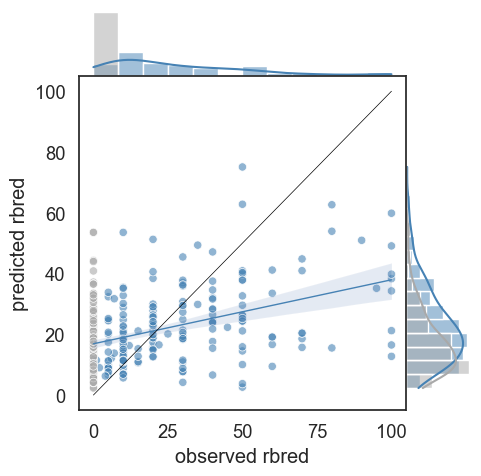

In [27]:

## final estimator
f.plot_observed_predicted(
    # finalmodel_y_test, finalmodel_y_pred,  
    me.residuals["y_true"], me.residuals["y_pred"],  
    hue=predicted_values[model_name]["dummy_obs_binary"], #results_p["chance of closs"],
    xlabel=f"observed {target}", ylabel=f"predicted {target}",
    # xlabel="observed rcloss", ylabel="predicted rcloss",
    legend=False, #True
    outfile= f"{OUTPATH_RESULTS}/scatter_obs_pred_ref_{target}_hcmc.png"
)       


## Transfer and apply best-performed RF model on CanTHo

In [28]:
# # df_cantho.columns
# # df_cantho = df_cantho[df_Xy.columns]
# # df_cantho
# # # df_Xy

# df_cantho = pd.read_excel(f"{INPATH_DATA}/input_data_businessreduction_tueb.xlsx")

# df_cantho.rename(columns=s.feature_names_plot, inplace=True) 

# df_cantho[df_Xy.columns]
# # 	rbred	inundation duration	water depth	contaminations	flow velocity	flood experience	building age	building area	mthly. income	emergency measures	no. employees	non-structural measures	structural measures	resilience	mthly. sales

In [29]:
logger.info("## Transfer and apply best-performed RF model on CanTHo")

## NOTE: can tho ds is already loaded in the beginning of the script were also the HCMC DS is loaded

##  use nice feature names
df_cantho.rename(columns=s.feature_names_plot, inplace=True) 


## prepare CanTHo for BN - adpat with same column structure as training dataset
df_cantho = df_cantho[df_Xy.columns]
df_cantho = df_cantho.dropna()


y_true_cantho = df_cantho[target]
df_cantho_X = df_cantho.drop(target, axis=1)
df_cantho.describe()

07-28-2024 02:09:53 - __reference_model_rbred__ - INFO - ## Transfer and apply best-performed RF model on CanTHo


,rbred,inundation duration,water depth,contaminations,flow velocity,flood experience,building age,building area,mthly. income,emergency measures,no. employees,non-structural measures,structural measures,resilience,mthly. sales
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,41.161049,4.219101,26.284644,0.715356,0.361049,42.719101,28.797753,96.861798,262.485019,0.300458,1.636704,0.296816,0.233458,2.767790,486.732210
std,21.581292,3.172919,15.617655,0.476386,0.110619,33.404782,14.539172,177.059603,273.050790,0.191680,1.194852,0.252169,0.206444,1.626384,1746.430001
min,0.000000,1.000000,0.000000,0.000000,0.100000,3.000000,8.000000,9.000000,10.700000,0.000000,1.000000,0.000000,0.000000,0.000000,12.800000
25%,30.000000,2.000000,15.000000,0.000000,0.300000,8.000000,16.000000,40.500000,149.600000,0.111111,1.000000,0.000000,0.000000,1.000000,85.600000
50%,40.000000,3.000000,20.000000,1.000000,0.400000,36.000000,26.000000,65.000000,149.600000,0.333333,1.000000,0.250000,0.333333,2.000000,171.000000
75%,50.000000,6.000000,40.000000,1.000000,0.400000,76.000000,36.000000,100.000000,320.600000,0.444444,2.000000,0.500000,0.333333,4.000000,384.700000
max,100.000000,24.000000,80.000000,2.000000,0.500000,76.000000,61.000000,2000.000000,2137.500000,0.888889,8.000000,1.000000,0.666667,6.000000,25650.200000


In [30]:
y_pred_cantho = final_model.predict(df_cantho_X)
y_pred_cantho.shape

(267,)

In [31]:
# evaluation metrics regiona ltransfered final RF estimator
MAE = eu.mean_absolute_error(y_true_cantho, y_pred_cantho)
MBE = eu.mean_bias_error(y_true_cantho, y_pred_cantho)
RMSE = eu.root_mean_squared_error(y_true_cantho, y_pred_cantho)
SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true_cantho, y_pred_cantho)


logger.info(f"Model perfromace on CanTho DS: MAE, MBE, RMSE, SMAPE: {MAE, MBE, RMSE, SMAPE}")  


logger.info(f"\nObserved and predicted target distribution from final model for CanTho ({target}):")
logger.info(eu.empirical_vs_predicted(y_true_cantho, y_pred_cantho))


07-28-2024 02:09:54 - __reference_model_rbred__ - INFO - Model perfromace on CanTho DS: MAE, MBE, RMSE, SMAPE: (26.21123595505618, -24.06247191011236, 33.09057486006081, 42.04390736682624)
07-28-2024 02:09:54 - __reference_model_rbred__ - INFO - 
Observed and predicted target distribution from final model for CanTho (rbred):
07-28-2024 02:09:54 - __reference_model_rbred__ - INFO -            nobs  median       mean   min max  variance  standard deviation   
empirical   267    40.0  41.161049  [0, 100]    465.75               21.54  \
predicted   267    15.0  16.617978   [5, 42]     46.34                6.79   

           coef. of variation  
empirical           52.431346  
predicted           40.964750  


In [32]:
pred_cd_cantho = pd.DataFrame({
    "y_true": pd.Series(y_true_cantho),
    "y_pred": pd.Series(y_pred_cantho),
    "residuals": pd.Series(y_pred_cantho) - pd.Series(y_true_cantho)},
    index=pd.Series(y_true_cantho).index
)

pred_cd_cantho.reset_index(drop=True, inplace=True)
logger.info(f"Statistics predictions, Can THo {pred_cd_cantho.describe()}")

for c in pred_cd_cantho.columns:
    ci = eu.calc_confidence_interval(pred_cd_cantho[c], 0.95)
    
pred_cd_cantho["y_true_binary"] = 0
idx_damage = np.where(pred_cd_cantho["y_true"] >= 1)[0]
pred_cd_cantho.loc[idx_damage, "y_true_binary"] = 1
pred_cd_cantho.describe()


07-28-2024 02:09:54 - __reference_model_rbred__ - INFO - Statistics predictions, Can THo            y_true      y_pred   residuals
count  267.000000  225.000000  225.000000
mean    41.161049   17.388711  -23.455733
std     21.581292    6.846640   21.695776
min      0.000000    5.330000  -88.350000
25%     30.000000   12.910000  -37.010000
50%     40.000000   15.540000  -21.850000
75%     50.000000   20.840000   -8.250000
max    100.000000   42.620000   34.340000


confidence interval: (38.56058740762597, 43.76150997065118),
cases within interval: 35
confidence interval: (nan, nan),
cases within interval: 0
confidence interval: (nan, nan),
cases within interval: 0


,y_true,y_pred,residuals,y_true_binary
count,267.000000,225.000000,225.000000,267.000000
mean,41.161049,17.388711,-23.455733,0.977528
std,21.581292,6.846640,21.695776,0.148491
min,0.000000,5.330000,-88.350000,0.000000
25%,30.000000,12.910000,-37.010000,1.000000
50%,40.000000,15.540000,-21.850000,1.000000
75%,50.000000,20.840000,-8.250000,1.000000
max,100.000000,42.620000,34.340000,1.000000


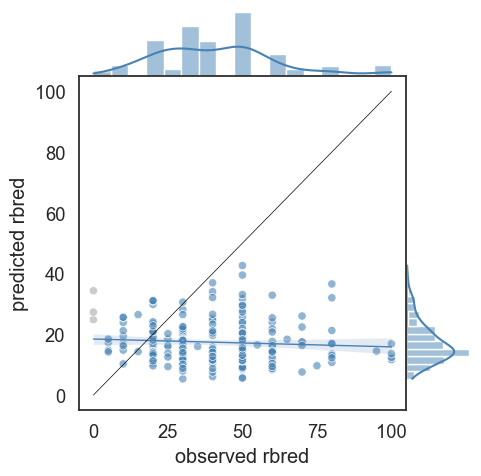

In [33]:

## final estimator
f.plot_observed_predicted(
    pred_cd_cantho["y_true"], pred_cd_cantho["y_pred"], 
    hue= pred_cd_cantho["y_true_binary"],
    xlabel=f"observed {target}", ylabel=f"predicted {target}",
    legend=False, #True
    outfile= f"{OUTPATH_RESULTS}/scatter_obs_pred_ref_{target}_cantho.png"
)       


In [34]:
results_p = df_cantho.copy() 
results_p["chance of closs"] = 0  # 0: no loss, 1: los occurrs

results_p["chance of closs"][results_p[target] == 0.0] = 0
results_p["chance of closs"][results_p[target] > 0.0 ] = 1
results_p["chance of closs"].describe()

count    267.000000
mean       0.977528
std        0.148491
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: chance of closs, dtype: float64

#### Plot CDFs

In [35]:
logger.info("Create cumulative distribution functions (CDFs)")

# pred_cd_cantho["residual"] = me.residuals["y_pred"], me.residuals["y_true"]  
pred_cd_cantho["residual"] = pred_cd_cantho["y_pred"] - pred_cd_cantho["y_true"]  

07-28-2024 02:09:56 - __reference_model_rbred__ - INFO - Create cumulative distribution functions (CDFs)


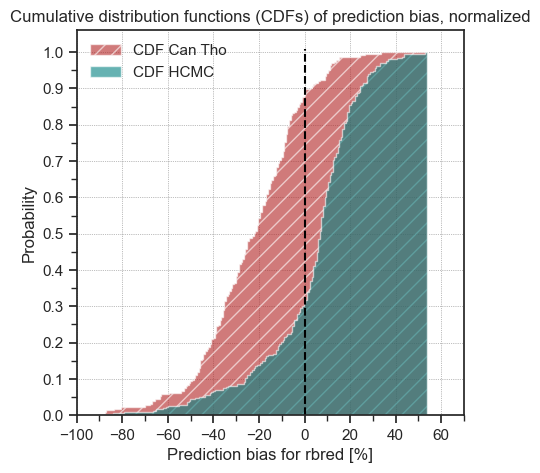

In [36]:
sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style(
    style="ticks",
     rc={"axes.grid" : False, "grid.linestyle": ":"}
     )


fig, ax = plt.subplots(1, 1, figsize=(5,5))

p, bins, patches  =  ax.hist(
    [me.residuals["residual"], pred_cd_cantho["residuals"]],  # pred HCMC+CanTHo rbred
    bins=200,
    density=True, # alias for normalize, last bins equals 1
    cumulative=True,  
    histtype='stepfilled', alpha=0.6,
    color=("teal","firebrick"), 
    label=( "CDF HCMC", "CDF Can Tho"),
)
# set hatch for Cna THo, to better distinguish the two distributions
for patch_set, hatch in zip(patches, ["", "//"]):
    plt.setp(patch_set, hatch=hatch)
ax.grid( which='major', color='grey', linewidth=0.5)

plt.xlim(-100, 70)
plt.xticks(np.arange(-100, 71, 20), minor=False)
plt.xticks(np.arange(-100, 71, 10), minor=True)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)


plt.xlabel(f"Prediction bias for {target} [%]")
plt.ylabel("Probability")
plt.legend(loc="best")

plt.vlines(x=0, ymin=0, ymax=1.01, colors="black", linestyles="--")

plt.title("Cumulative distribution functions (CDFs) of prediction bias, normalized")
# plt.savefig(OUTPATH_RESULTS + f"./cdf_ref_degree.png", dpi=300, bbox_inches="tight")
plt.savefig(OUTPATH_RESULTS + f"./cdf_ref_{target}.png", dpi=300, bbox_inches="tight")




####

In [37]:
df_Xy.describe()

,rbred,inundation duration,water depth,contaminations,flow velocity,flood experience,building age,building area,mthly. income,emergency measures,no. employees,non-structural measures,structural measures,resilience,mthly. sales
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,17.814696,11.264217,33.744409,0.980831,0.308626,82.738019,20.143770,86.020767,433.674760,0.422790,1.894569,0.378594,0.230032,2.605431,378.858147
std,24.276271,29.322452,25.905372,0.391762,0.127685,53.414577,14.525898,89.281120,376.684503,0.262478,1.260241,0.300302,0.274082,1.070467,463.066786
min,0.000000,0.200000,1.000000,0.000000,0.100000,3.000000,0.000000,12.000000,18.400000,0.000000,1.000000,0.000000,0.000000,0.000000,92.100000
25%,0.000000,2.000000,10.000000,1.000000,0.200000,36.000000,12.000000,42.000000,294.600000,0.166667,1.000000,0.250000,0.000000,1.750000,92.100000
50%,10.000000,3.000000,30.000000,1.000000,0.300000,76.000000,18.000000,74.000000,294.600000,0.500000,2.000000,0.250000,0.000000,2.500000,276.200000
75%,30.000000,6.000000,50.000000,1.000000,0.400000,151.000000,25.000000,100.000000,552.400000,0.666667,2.000000,0.500000,0.500000,3.500000,276.200000
max,100.000000,240.000000,150.000000,2.000000,0.500000,151.000000,100.000000,850.000000,3314.300000,1.000000,9.000000,1.000000,1.000000,5.000000,2761.900000
